Nama : Jonathan William Gunawan

NIM : 2702251794

In [49]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
import imghdr
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

In [28]:
# path = '/Users/jowillg/Semester 4/Deep Learning/UAS/NO 2'
# image_path = os.path.join(path, 'A_23')
# image_files = os.listdir(image_path)
# sample_files = random.sample(image_files, 5)

image_path = '/kaggle/input/kacang-pistachio/A_23'
image_files = os.listdir(image_path)
sample_files = random.sample(image_files, 5)

## A. EDA

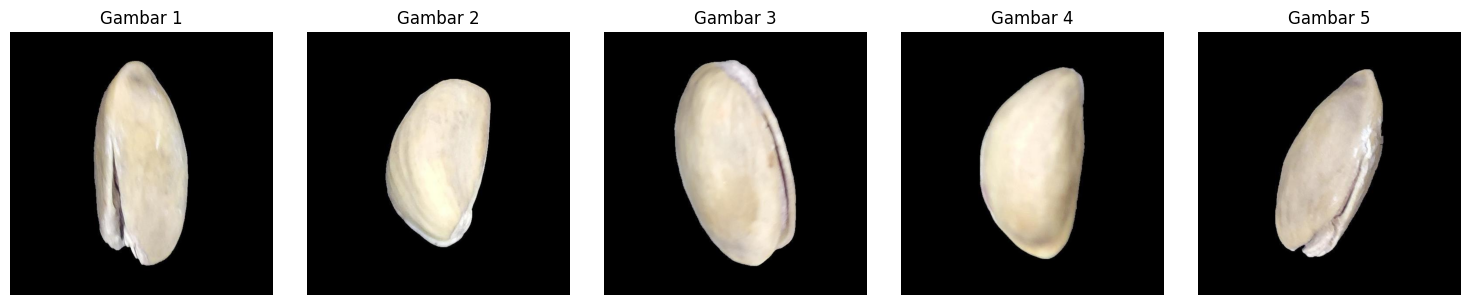

In [29]:
plt.figure(figsize=(15, 3))
for i, filename in enumerate(sample_files):
    img_path = os.path.join(image_path, filename)
    img = cv2.imread(img_path)             
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Gambar {i+1}")

plt.tight_layout()
plt.show()

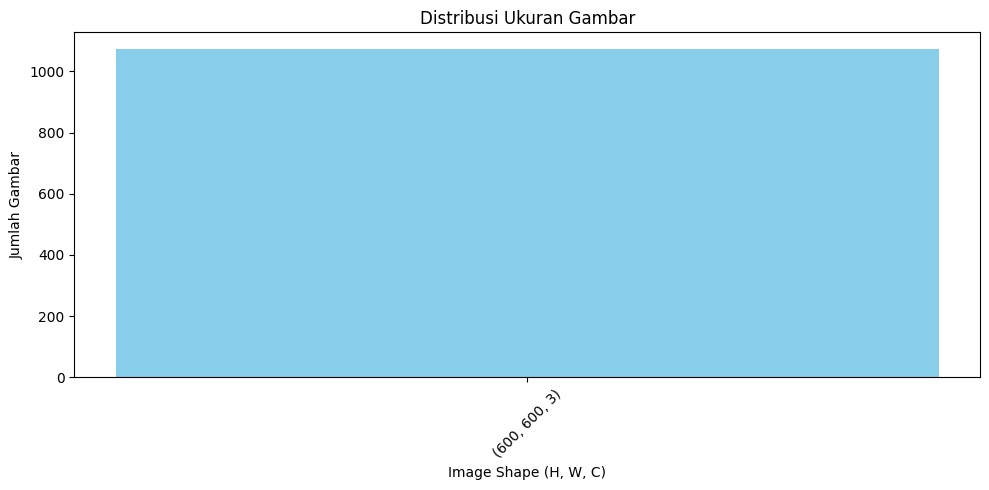

In [30]:
from collections import Counter

shapes = []
for filename in image_files:
    img_path = os.path.join(image_path, filename)
    img = cv2.imread(img_path)
    if img is not None:
        shapes.append(img.shape)

shape_counts = Counter(shapes)
labels = [str(shape) for shape in shape_counts.keys()]
counts = list(shape_counts.values())

# Plot
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Image Shape (H, W, C)")
plt.ylabel("Jumlah Gambar")
plt.title("Distribusi Ukuran Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Melihat distribusi shape gambar apakah semuanya mempunya input shape yang sama

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


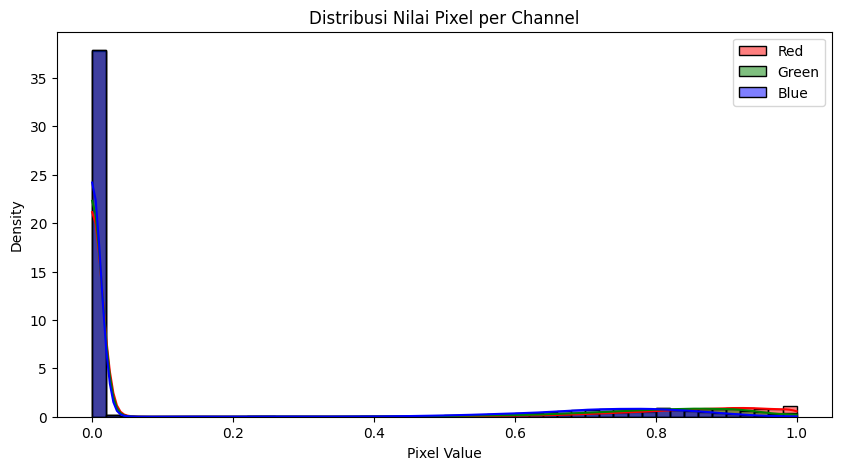

In [31]:
r_values, g_values, b_values = [], [], []

for filename in image_files:
    img_path = os.path.join(image_path, filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img is not None:
        img = cv2.resize(img, (100, 100))
        img = img / 255.0
        r, g, b = cv2.split(img)  
        r_values.extend(r.flatten())
        g_values.extend(g.flatten())
        b_values.extend(b.flatten())

# Plot per channel
plt.figure(figsize=(10, 5))
sns.histplot(r_values, bins=50, kde=True, color='red', label='Red', stat='density')
sns.histplot(g_values, bins=50, kde=True, color='green', label='Green', stat='density')
sns.histplot(b_values, bins=50, kde=True, color='blue', label='Blue', stat='density')
plt.title("Distribusi Nilai Pixel per Channel")
plt.xlabel("Pixel Value")
plt.ylabel("Density")
plt.legend()
plt.show()


Dapat dilihat bahwa sebagian besar pixel nilainya sangat rendah artinya gambar gambar dari dataset itu cenderung gelap. Hal ini disebabkan karena background gambarnya adalah hitam, karena backgroundnya mendominasi, model mungkin lebih pintar untuk memprediksi background

## B. Preprocessing

In [32]:
images = []

for filename in image_files:
    img_full_path = os.path.join(image_path, filename)
    img = cv2.imread(img_full_path)
    img = cv2.resize(img, (100, 100))  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255.0
    images.append(img)

images = np.array(images)

In [33]:
x_train, x_test = train_test_split(images, test_size=0.2, random_state=SEED_VALUE)
x_val, x_test = train_test_split(x_test, test_size=0.5, random_state=SEED_VALUE)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(859, 100, 100, 3)
(107, 100, 100, 3)
(108, 100, 100, 3)


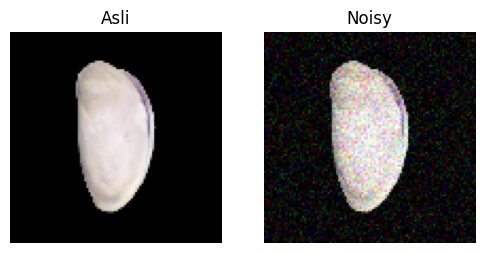

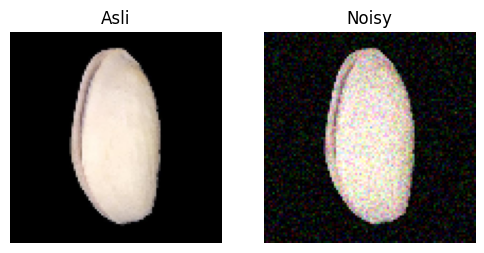

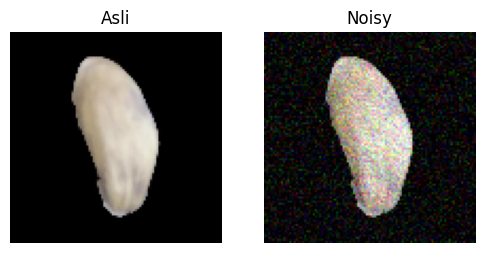

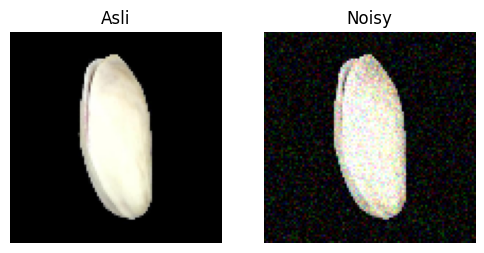

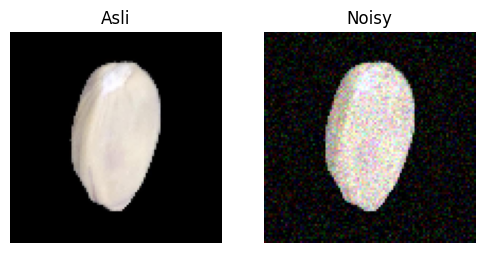

In [34]:
def gaussian_noise(images, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)  # supaya tetap dalam range [0, 1]
    return noisy_images

x_train_noisy = gaussian_noise(x_train)
x_val_noisy   = gaussian_noise(x_val)
x_test_noisy  = gaussian_noise(x_test)

for i in range(5) :
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(x_train[i])
    plt.title("Asli")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(x_train_noisy[i])
    plt.title("Noisy")
    plt.axis("off")
    plt.show()

Menambahkan noise terhadap gambar agar autoencoder dapat dilatih menggunakan gambar yang bernoise dan menghasilkan gambar yang asli

In [35]:
class DisplayCallback(Callback):
    def __init__(self, val_data, interval=5, num_images=3):
        super().__init__()
        self.val_data = val_data  
        self.interval = interval
        self.num_images = num_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval != 0:
            return

        print(f"\nDisplaying reconstructions at epoch {epoch + 1}")

        # Ambil batch pertama dari val_data
        if isinstance(self.val_data, tf.data.Dataset):
            for noisy_batch, clean_batch in self.val_data.take(1):
                break
        else:
            noisy_batch = self.val_data[0][:self.num_images]
            clean_batch = self.val_data[1][:self.num_images]

        pred_batch = self.model.predict(noisy_batch[:self.num_images])

        # Tampilkan
        plt.figure(figsize=(10, self.num_images * 3))
        for i in range(self.num_images):
            # Gambar asli
            plt.subplot(self.num_images, 3, i * 3 + 1)
            plt.imshow(clean_batch[i])
            plt.title("Asli")
            plt.axis("off")

            # Gambar noisy
            plt.subplot(self.num_images, 3, i * 3 + 2)
            plt.imshow(noisy_batch[i])
            plt.title("Noise")
            plt.axis("off")

            # Gambar prediksi
            plt.subplot(self.num_images, 3, i * 3 + 3)
            plt.imshow(pred_batch[i])
            plt.title("Prediksi")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


Buat menghasilkan plot saat pelatihan tiap 5 epoch, ini untuk melihat progress model dalam memprediksi ground truth

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)).shuffle(buffer_size=len(x_train)).batch(8).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val_noisy, x_val)).batch(8).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).batch(8).prefetch(AUTOTUNE)

## C. Model

In [37]:
def autoencoder(input_shape=(100,100,3)):
    input_layer = Input(shape=input_shape)

    #Encoder
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)

    #Bottleneck
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)

    #Decoder
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)

    output_layer = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [38]:
model = autoencoder()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 100, 100, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 25, 25, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 50, 50, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 100, 100, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mae',
              metrics=['mse'])

In [40]:
check_point = EarlyStopping(
    monitor = 'val_loss',
    mode = 'min',
    patience = 5
)

display_callback = DisplayCallback(val_ds, interval=5, num_images=3)

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3721 - mse: 0.1645 - val_loss: 0.0548 - val_mse: 0.0140
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0447 - mse: 0.0111 - val_loss: 0.0308 - val_mse: 0.0058
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0281 - mse: 0.0055 - val_loss: 0.0247 - val_mse: 0.0049
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0222 - mse: 0.0041 - val_loss: 0.0219 - val_mse: 0.0038
Epoch 5/20
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - mse: 0.0036
Displaying reconstructions at epoch 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


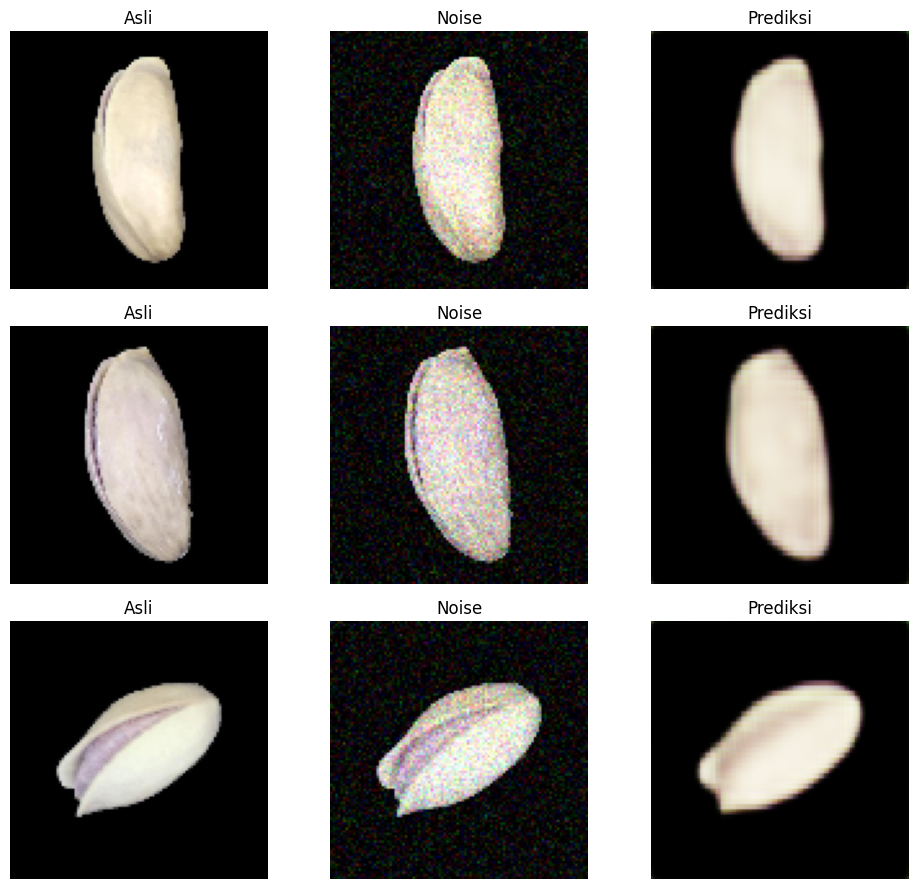

108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0203 - mse: 0.0036 - val_loss: 0.0203 - val_mse: 0.0035
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - mse: 0.0032 - val_loss: 0.0189 - val_mse: 0.0032
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0179 - mse: 0.0030 - val_loss: 0.0182 - val_mse: 0.0030
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0171 - mse: 0.0028 - val_loss: 0.0172 - val_mse: 0.0028
Epoch 9/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0165 - mse: 0.0027 - val_loss: 0.0170 - val_mse: 0.0027
Epoch 10/20
105/108 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - mse: 0.0026
Displaying reconstructions at epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


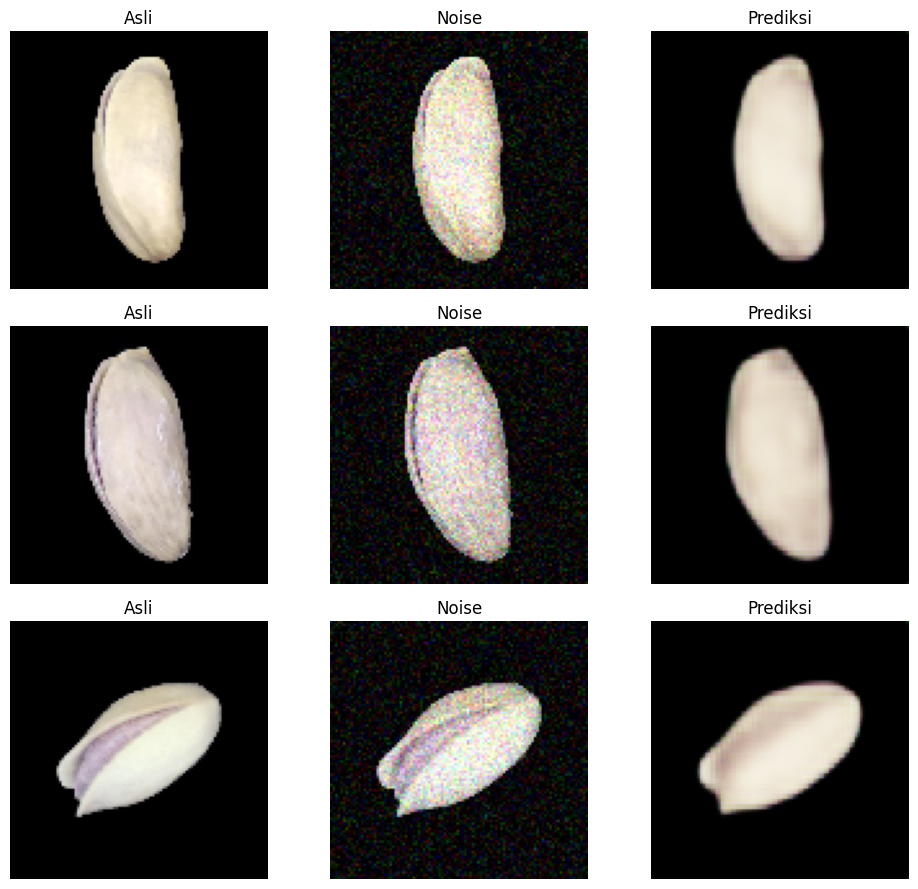

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0163 - mse: 0.0026 - val_loss: 0.0162 - val_mse: 0.0025
Epoch 11/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0158 - mse: 0.0024 - val_loss: 0.0165 - val_mse: 0.0025
Epoch 12/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0153 - mse: 0.0023 - val_loss: 0.0160 - val_mse: 0.0025
Epoch 13/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0150 - mse: 0.0023 - val_loss: 0.0157 - val_mse: 0.0024
Epoch 14/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147 - mse: 0.0022 - val_loss: 0.0151 - val_mse: 0.0023
Epoch 15/20
102/108 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - mse: 0.0021
Displaying reconstructions at epoch 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


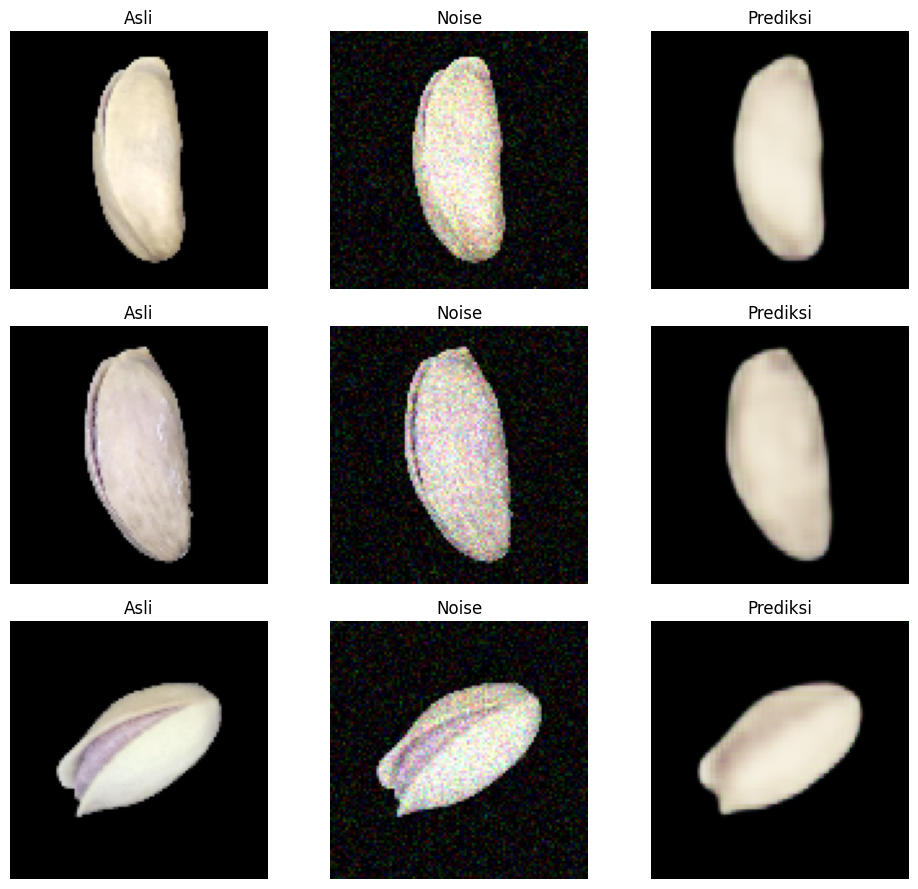

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0144 - mse: 0.0021 - val_loss: 0.0147 - val_mse: 0.0022
Epoch 16/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0145 - mse: 0.0021 - val_loss: 0.0146 - val_mse: 0.0021
Epoch 17/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0142 - mse: 0.0020 - val_loss: 0.0144 - val_mse: 0.0021
Epoch 18/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - mse: 0.0020 - val_loss: 0.0142 - val_mse: 0.0020
Epoch 19/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0137 - mse: 0.0019 - val_loss: 0.0141 - val_mse: 0.0020
Epoch 20/20
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - mse: 0.0018
Displaying reconstructions at epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


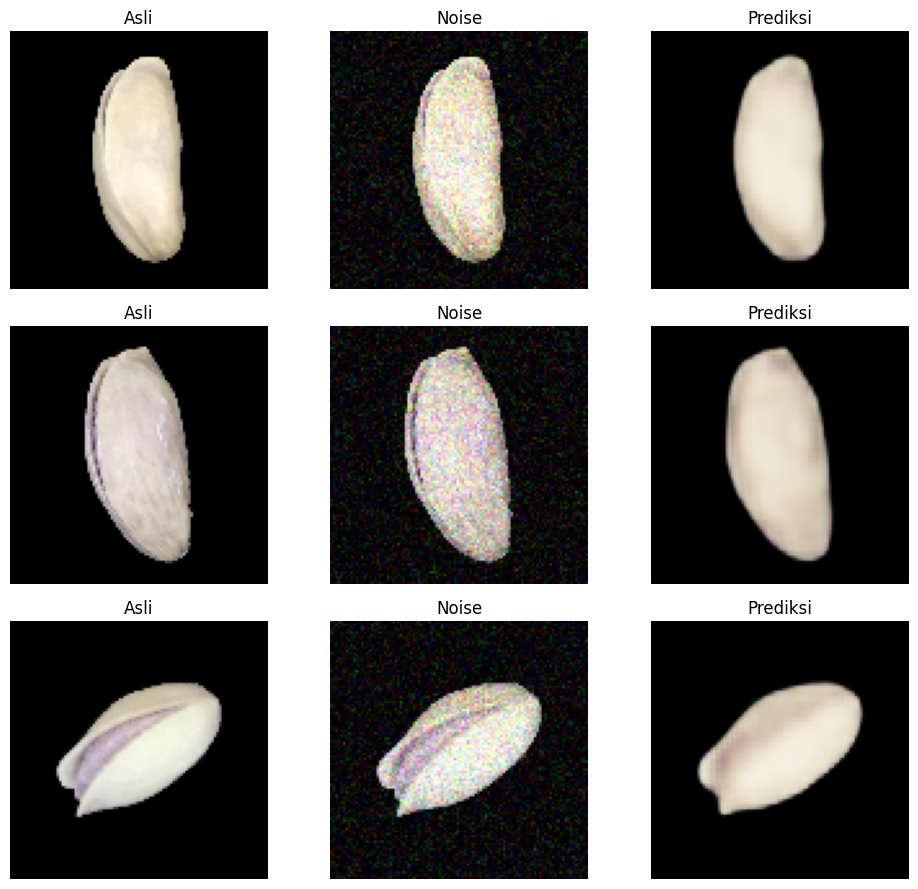

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0134 - mse: 0.0018 - val_loss: 0.0139 - val_mse: 0.0019


In [41]:
history = model.fit(train_ds, 
                    validation_data = val_ds, 
                    epochs=20,
                    callbacks=[check_point,display_callback])

Dapat dilihat bahwa model sudah lumayan baik dalam menghilang noisenya, tetapi model kurang baik dalam menangkap detail dari ground truthnya. 

## D. Modifikasi Model

In [48]:
from tensorflow.keras.layers import Concatenate

def unet_denoiser(input_shape=(100, 100, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(64, (3,3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2,2))(c2)

    # Bottleneck
    b = Conv2D(128, (3,3), activation='relu', padding='same')(p2)

    # Decoder
    u1 = UpSampling2D((2,2))(b)
    m1 = Concatenate()([u1, c2])
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(m1)

    u2 = UpSampling2D((2,2))(c3)
    m2 = Concatenate()([u2, c1])
    c4 = Conv2D(32, (3,3), activation='relu', padding='same')(m2)

    outputs = Conv2D(3, (3,3), activation='sigmoid', padding='same')(c4)

    return Model(inputs, outputs)

In [45]:
u_model = unet_denoiser()
u_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 100, 100, 32)   │            896 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 50, 50, 32)     │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 50, 50, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 25, 25, 64)     │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 25, 25, 128)    │         73,856 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_7           │ (None, 50, 50, 128)    │              0 │ conv2d_20[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 50, 50, 192)    │              0 │ up_sampling2d_7[0][0], │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 50, 50, 64)     │        110,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 100, 100, 64)   │              0 │ conv2d_21[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100, 100, 96)   │              0 │ up_sampling2d_8[0][0], │
│ (Concatenate)             │                        │                │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 100, 100, 32)   │         27,680 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 100, 100, 3)    │             99 │ conv2d_22[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 231,683 (905.01 KB)

 Trainable params: 231,683 (905.01 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
u_model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='mse',
              metrics=['mae'])

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - loss: 0.3204 - mse: 0.1388 - val_loss: 0.0387 - val_mse: 0.0099
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0295 - mse: 0.0063 - val_loss: 0.0198 - val_mse: 0.0030
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0187 - mse: 0.0028 - val_loss: 0.0199 - val_mse: 0.0028
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0166 - mse: 0.0023 - val_loss: 0.0153 - val_mse: 0.0020
Epoch 5/20
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0148 - mse: 0.0019
Displaying reconstructions at epoch 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step


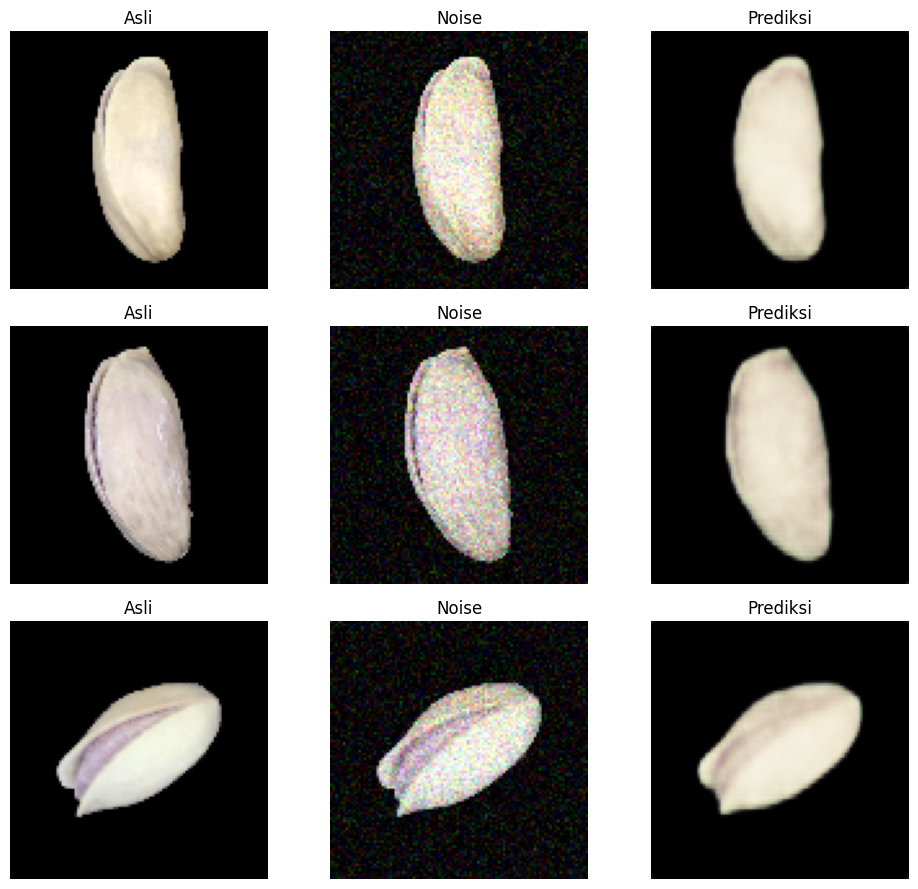

108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0148 - mse: 0.0019 - val_loss: 0.0143 - val_mse: 0.0017
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0138 - mse: 0.0017 - val_loss: 0.0140 - val_mse: 0.0016
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0133 - mse: 0.0015 - val_loss: 0.0131 - val_mse: 0.0015
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0122 - mse: 0.0013 - val_loss: 0.0119 - val_mse: 0.0012
Epoch 9/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0117 - mse: 0.0012 - val_loss: 0.0124 - val_mse: 0.0013
Epoch 10/20
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0114 - mse: 0.0011
Displaying reconstructions at epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


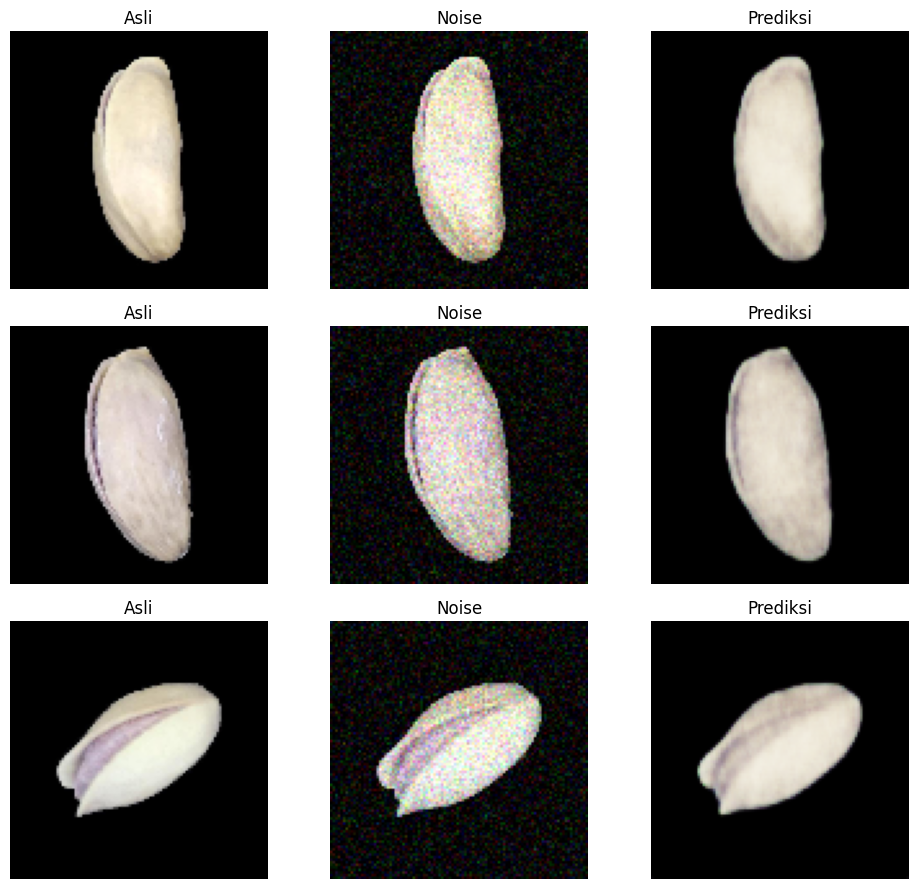

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0114 - mse: 0.0011 - val_loss: 0.0114 - val_mse: 0.0011
Epoch 11/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0107 - mse: 9.8528e-04 - val_loss: 0.0105 - val_mse: 9.5264e-04
Epoch 12/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0102 - mse: 8.9470e-04 - val_loss: 0.0117 - val_mse: 0.0011
Epoch 13/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0098 - mse: 8.1667e-04 - val_loss: 0.0109 - val_mse: 9.3650e-04
Epoch 14/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0101 - mse: 8.2345e-04 - val_loss: 0.0102 - val_mse: 8.1368e-04
Epoch 15/20
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0094 - mse: 7.1944e-04
Displaying reconstructions at epoch 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


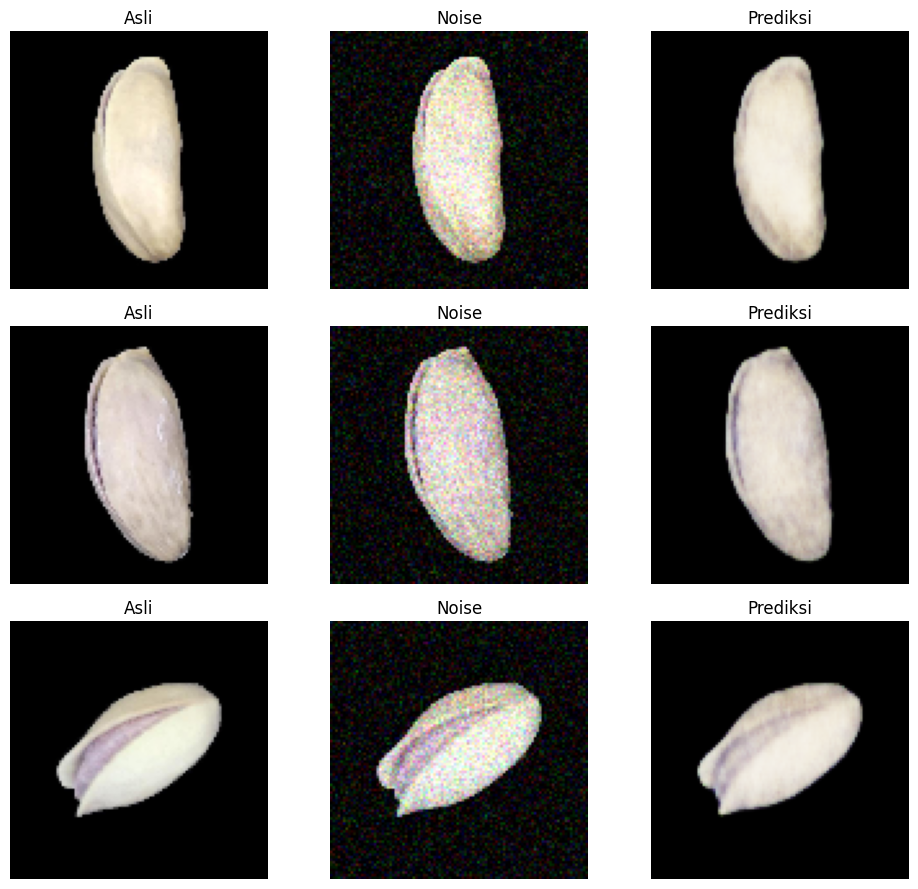

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0094 - mse: 7.1903e-04 - val_loss: 0.0095 - val_mse: 7.3470e-04
Epoch 16/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0091 - mse: 6.7521e-04 - val_loss: 0.0088 - val_mse: 6.4590e-04
Epoch 17/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0087 - mse: 6.1735e-04 - val_loss: 0.0087 - val_mse: 6.2943e-04
Epoch 18/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0085 - mse: 5.8321e-04 - val_loss: 0.0088 - val_mse: 6.0836e-04
Epoch 19/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0086 - mse: 5.8790e-04 - val_loss: 0.0084 - val_mse: 5.6153e-04
Epoch 20/20
106/108 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0082 - mse: 5.3347e-04
Displaying reconstructions at epoch 20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


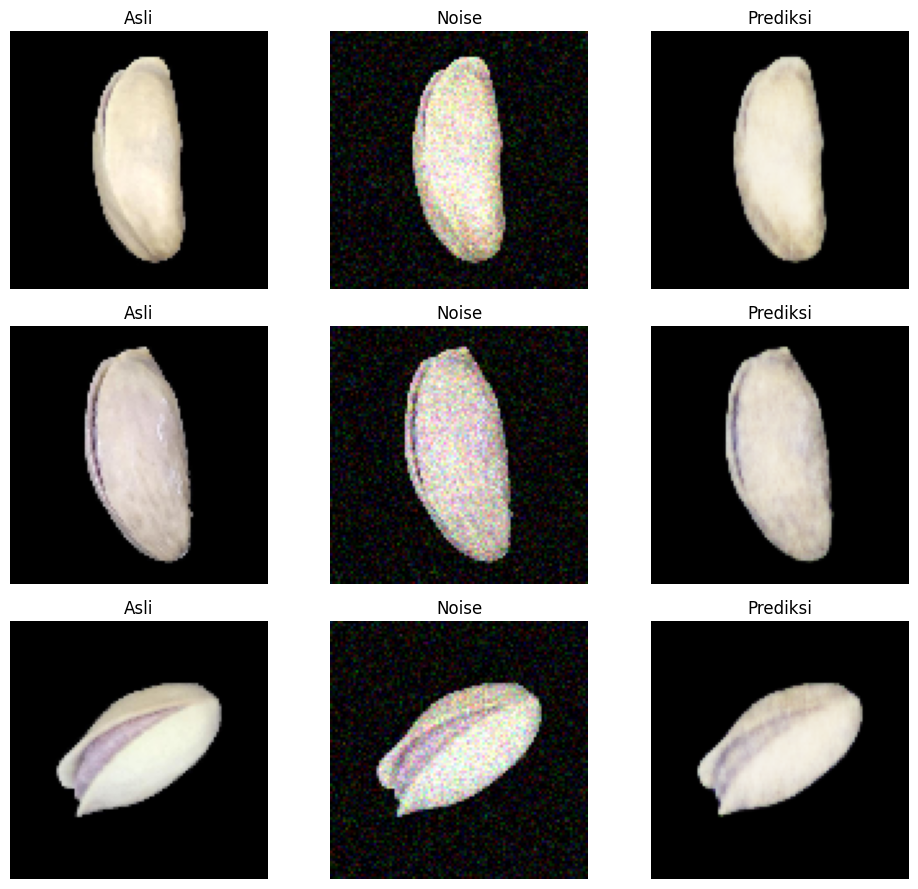

108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0082 - mse: 5.3348e-04 - val_loss: 0.0085 - val_mse: 5.5566e-04


In [47]:
history = u_model.fit(train_ds,
                    validation_data=val_ds, 
                    epochs=20,
                    batch_size=8,
                    callbacks=[check_point, display_callback])

Dapat dilihat jika kita menggunakan simple u-net model, hasilnya lebih baik, model dapat menghilangkan noise dan dalam epoch ke 20 dia sudah bisa merekonstruksi sedikit detail. Secara overral model ini lebih bagus dari pada baseline  

### Hyperparameter Tuning

In [51]:
import keras_tuner as kt


def build_unet_tuned(hp):
    inputs = Input(shape=(100, 100, 3))

    # Encoder
    c1 = Conv2D(hp.Int('enc1_filters', 32, 128, step=32), (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(hp.Int('enc2_filters', 64, 256, step=64), (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    # Bottleneck
    b = Conv2D(hp.Int('bottleneck_filters', 128, 512, step=128), (3,3), padding='same')(p2)
    b = BatchNormalization()(b)
    b = Activation('relu')(b)

    # Decoder
    u1 = UpSampling2D((2,2))(b)
    m1 = Concatenate()([u1, c2])
    c3 = Conv2D(hp.Int('dec1_filters', 64, 256, step=64), (3,3), padding='same')(m1)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)

    u2 = UpSampling2D((2,2))(c3)
    m2 = Concatenate()([u2, c1])
    c4 = Conv2D(hp.Int('dec2_filters', 32, 128, step=32), (3,3), padding='same')(m2)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    outputs = Conv2D(3, (3,3), activation='sigmoid', padding='same')(c4)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )

    return model


In [55]:
from keras_tuner import Hyperband

tuner = Hyperband(
    build_unet_tuned,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='u_net_tuning_final',
    overwrite=True
)

tuner.search(train_ds,
             validation_data=val_ds,
             callbacks=[check_point])

Trial 60 Complete [00h 02m 45s]
val_loss: 0.000311834504827857

Best val_loss So Far: 0.0002997863048221916
Total elapsed time: 01h 02m 49s


In [58]:
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hp)
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

enc1_filters: 64
enc2_filters: 256
bottleneck_filters: 384
dec1_filters: 64
dec2_filters: 128
lr: 0.01
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0051


Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 0.0687 - mae: 0.1126 - val_loss: 0.0585 - val_mae: 0.1229
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0013 - mae: 0.0128 - val_loss: 0.0066 - val_mae: 0.0376
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 7.7082e-04 - mae: 0.0100 - val_loss: 0.0041 - val_mae: 0.0296
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.3802e-04 - mae: 0.0094 - val_loss: 0.0034 - val_mae: 0.0245
Epoch 5/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 5.4082e-04 - mae: 0.0087
Displaying reconstructions at epoch 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


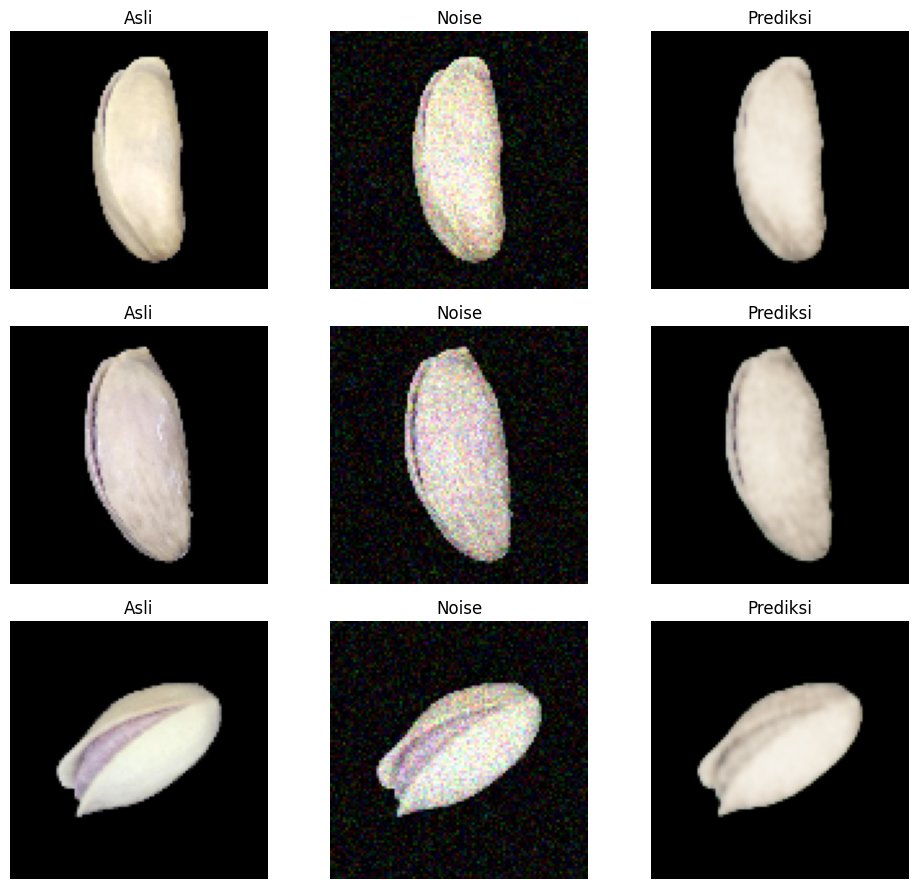

108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 5.4106e-04 - mae: 0.0087 - val_loss: 7.0641e-04 - val_mae: 0.0093
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 5.5107e-04 - mae: 0.0089 - val_loss: 5.3089e-04 - val_mae: 0.0086
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 4.7124e-04 - mae: 0.0083 - val_loss: 9.9533e-04 - val_mae: 0.0127
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 5.0743e-04 - mae: 0.0086 - val_loss: 7.6510e-04 - val_mae: 0.0113
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 4.8693e-04 - mae: 0.0085 - val_loss: 4.3959e-04 - val_mae: 0.0082
Epoch 10/50
107/108 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.5117e-04 - mae: 0.0082
Displaying reconstructions at epoch 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


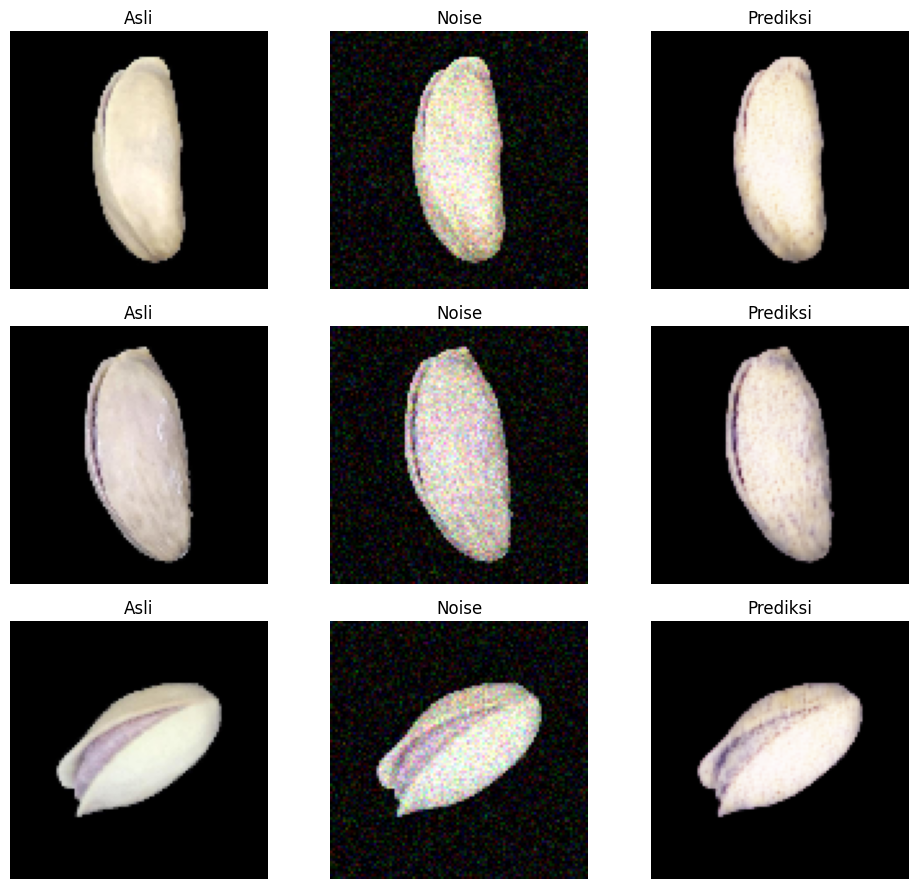

108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 4.5099e-04 - mae: 0.0082 - val_loss: 8.4615e-04 - val_mae: 0.0118
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 4.6611e-04 - mae: 0.0083 - val_loss: 5.7076e-04 - val_mae: 0.0096
Epoch 12/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 4.1489e-04 - mae: 0.0078 - val_loss: 6.0499e-04 - val_mae: 0.0099
Epoch 13/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 4.1542e-04 - mae: 0.0079 - val_loss: 4.8240e-04 - val_mae: 0.0084
Epoch 14/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 3.8233e-04 - mae: 0.0075 - val_loss: 5.9460e-04 - val_mae: 0.0098


In [59]:
history = best_model.fit(train_ds,
                    validation_data=val_ds, 
                    epochs=50,
                    batch_size=8,
                    callbacks=[check_point, display_callback])

## E. Evaluasi

In [63]:
#Function Average SSIM
def evaluate_ssim(model, test_dataset, max_val=1.0):
    ssim_scores = []

    for noisy_batch, original_batch in test_dataset:
        pred_batch = model.predict(noisy_batch, verbose=0)

        # Hitung SSIM per gambar
        for i in range(len(original_batch)):
            ssim = tf.image.ssim(
                original_batch[i], pred_batch[i], max_val=max_val
            ).numpy()
            ssim_scores.append(ssim)

    return np.mean(ssim_scores)

#### Baseline Model

In [64]:
mean_ssim = evaluate_ssim(model, test_ds)
print("SSIM model biasa:", mean_ssim)

SSIM model biasa: 0.9196658


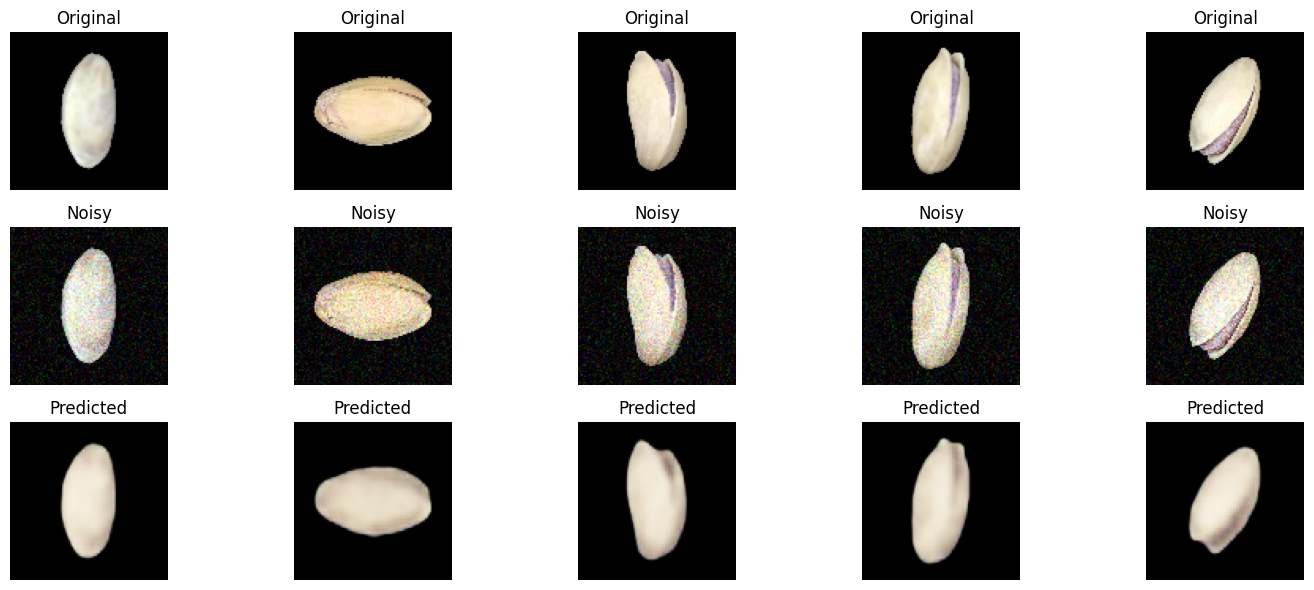

In [70]:
for noisy_imgs, clean_imgs in test_ds.take(1):
    denoised_imgs = model.predict(noisy_imgs, verbose=0)

    batch_size = noisy_imgs.shape[0]
    random_indices = random.sample(range(batch_size), 5)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(random_indices):
        # 1. Gambar asli (ground truth)
        plt.subplot(3, 5, i + 1)
        plt.imshow(clean_imgs[idx].numpy().squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # 2. Gambar input noisy
        plt.subplot(3, 5, i + 6)  # baris kedua
        plt.imshow(noisy_imgs[idx].numpy().squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # 3. Gambar hasil prediksi (denoised)
        plt.subplot(3, 5, i + 11)  # baris ketiga
        plt.imshow(denoised_imgs[idx].squeeze(), cmap='gray')
        plt.title("Predicted")
        plt.axis('off')

    

    plt.tight_layout()
    plt.show()
    break  # hanya satu batch


#### U-Net Tuned Model

In [65]:
mean_ssim_best = evaluate_ssim(best_model, test_ds)
print("SSIM model tuning terbaik:", mean_ssim_best)

SSIM model tuning terbaik: 0.96130943


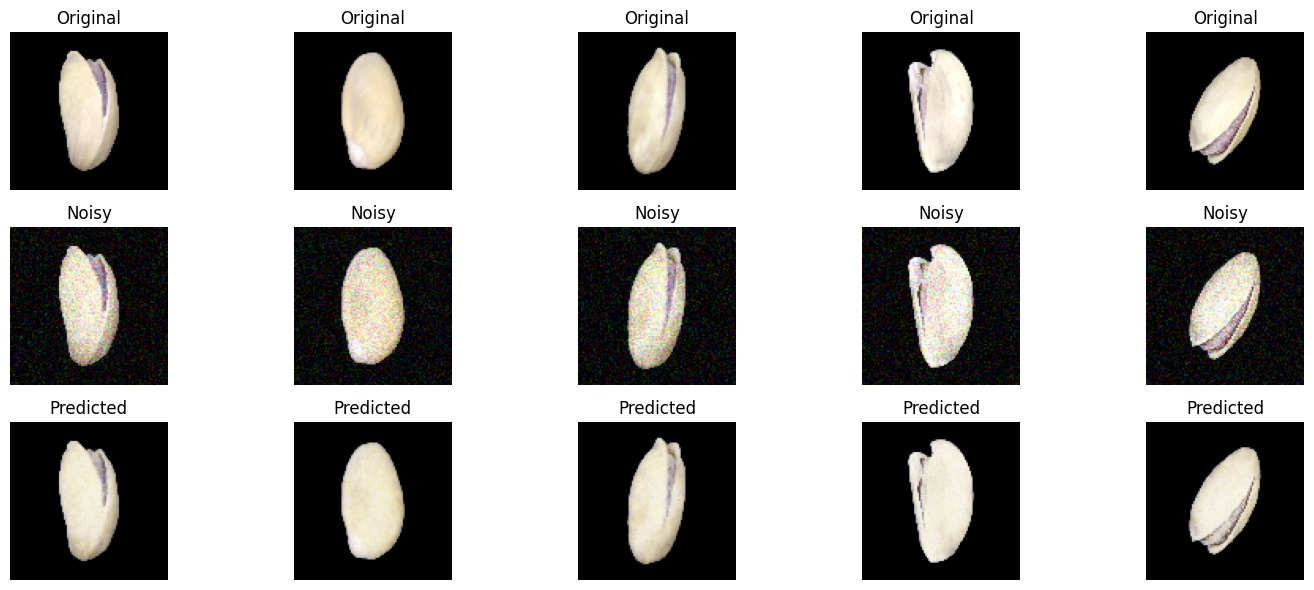

In [71]:
for noisy_imgs, clean_imgs in test_ds.take(1):
    denoised_imgs = best_model.predict(noisy_imgs, verbose=0)

    batch_size = noisy_imgs.shape[0]
    random_indices = random.sample(range(batch_size), 5)

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(random_indices):
        # 1. Gambar asli (ground truth)
        plt.subplot(3, 5, i + 1)
        plt.imshow(clean_imgs[idx].numpy().squeeze(), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # 2. Gambar input noisy
        plt.subplot(3, 5, i + 6)  # baris kedua
        plt.imshow(noisy_imgs[idx].numpy().squeeze(), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # 3. Gambar hasil prediksi (denoised)
        plt.subplot(3, 5, i + 11)  # baris ketiga
        plt.imshow(denoised_imgs[idx].squeeze(), cmap='gray')
        plt.title("Predicted")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    break  # hanya satu batch


Dapat dilihat dari hasil SSIM, model pertama memiliki SSIM 0.92 dan Model kedua yaitu U-Net yang dituning memiliki SSIM 0.96. Model kedua lebih baik dalam denoising karena U-net memiliki concatenate layer yang menghubungkan output di encode layer dan di decode layer. Ini membuat ada informasi tambahan dari layer sebelumnya itu tidak hilang saat di downsampling sehingga lebih baik dalam menangkap detail, tetapi sayangnya kalau dilihat dari predicted gambarnya U-net memiliki noise lebih banyak daripada baseline

link penjelasan video : https://drive.google.com/file/d/1F1q3p8QogvW08PzbeGGgcd4QZQrd0DL2/view?usp=share_link